In [42]:
# Import all the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

In [43]:
# Download the anime images dataset

import io
import requests

def load_images_from_zip(zip_file):
  with zipfile.ZipFile(zip_file,'r') as zip_ref:
    images = {'anastasia':[],'takao':[]}
    for file_name in zip_ref.namelist():
      if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['anastasia'].append(np.array(img))
      elif file_name.startswith('takao') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['takao'].append(np.array(img))

  return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

images = load_images_from_zip(zip_file_bytes)

In [44]:
# Check the number of images for each class

print('Number of images of Anastasia:',len(images['anastasia']))
print('Nuber of images of Takao:',len(images['takao']))

Number of images of Anastasia: 50
Nuber of images of Takao: 50


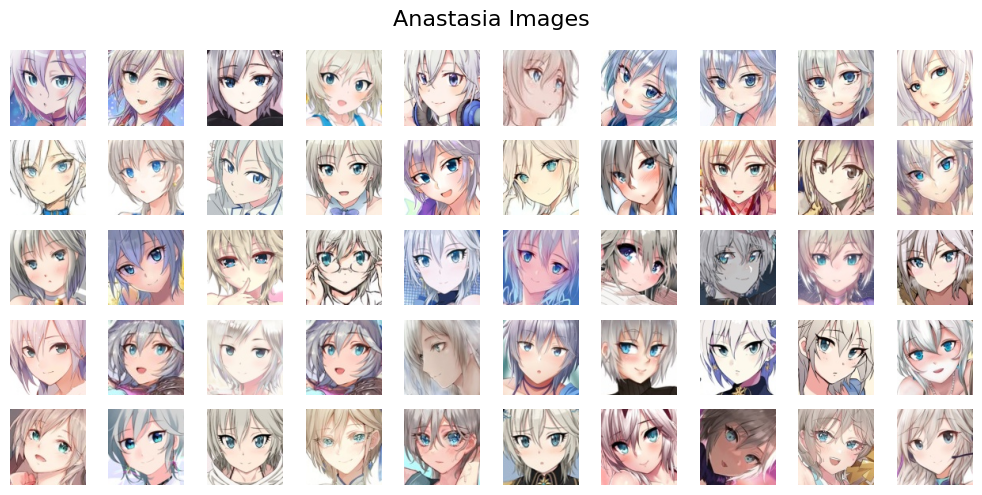

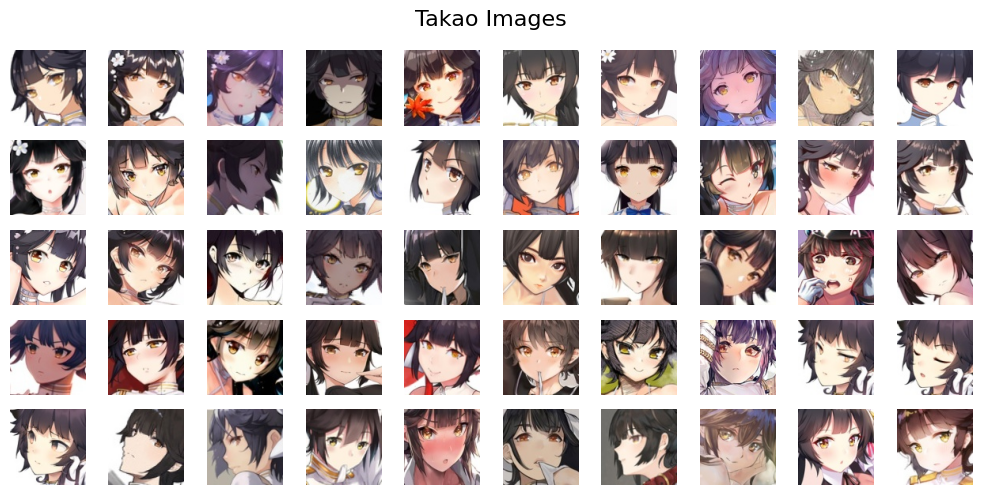

In [45]:
# Function to plot anime images

def plot_images(images,title):
  fig,axes = plt.subplots(5,10,figsize=(10,5))
  fig.suptitle(title,fontsize=16)
  axes = axes.flatten()
  for img,ax in zip(images,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

# Plot the images

plot_images(images['anastasia'],'Anastasia Images')
plot_images(images['takao'],'Takao Images')

In [46]:
# Custom dataset class

class AnimeDataset(Dataset):
  def __init__(self,images,transform=None,classes=None):
    self.images=[]
    self.labels=[]
    self.transform=transform
    self.classes=classes

    for label,class_name in enumerate(self.classes):
      for img in images[class_name]:
        self.images.append(img)
        self.labels.append(label)

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    image = Image.fromarray(self.images[idx])
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image,label

# Transforms for the images

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Build the dataset with custom transforms

dataset = AnimeDataset(images,transform=transform,classes=['anastasia','takao'])

In [47]:
# Split the dataset to training and testing sets

from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

indices = list(range(len(dataset)))

train_indices,val_indices = train_test_split(indices,test_size=0.2,random_state=seed)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset,batch_size=8,sampler=train_sampler)
val_loader = DataLoader(dataset,batch_size=20,sampler=val_sampler)

print('Train Size:',len(train_indices))
print('Validation Size:',len(val_indices))

Train Size: 80
Validation Size: 20


In [48]:
# Create a CNN model for anime classification

import torch.nn as nn
import torch.nn.functional as F

class AnimeCNN(nn.Module):
  def __init__(self):
    super(AnimeCNN,self).__init__()
    self.conv1 = nn.Conv2d(3,32,3,1,padding=1)
    self.conv2 = nn.Conv2d(32,64,3,1,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*16*16,128)
    self.fc2 = nn.Linear(128,2)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,64*16*16)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Call the model

model = AnimeCNN()

In [49]:
# Check the layers of the model

print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [50]:
# Check the input and output sizes of each layer in the model

input_tensor = torch.randn(1,3,64,64)

def print_size(module,input,output):
  print(f'{module.__class__.__name__}, input size: {input[0].size()}, output size: {output.size()}')

hooks = []
for layer in model.children():
  hook = layer.register_forward_hook(print_size)
  hooks.append(hook)

with torch.no_grad():
  output = model(input_tensor)
print('Final output size:',output.size())

for hook in hooks:
  hook.remove()

Conv2d, input size: torch.Size([1, 3, 64, 64]), output size: torch.Size([1, 32, 64, 64])
MaxPool2d, input size: torch.Size([1, 32, 64, 64]), output size: torch.Size([1, 32, 32, 32])
Conv2d, input size: torch.Size([1, 32, 32, 32]), output size: torch.Size([1, 64, 32, 32])
MaxPool2d, input size: torch.Size([1, 64, 32, 32]), output size: torch.Size([1, 64, 16, 16])
Linear, input size: torch.Size([1, 16384]), output size: torch.Size([1, 128])
Linear, input size: torch.Size([1, 128]), output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


In [51]:
# Create loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [52]:
# Train the model on the dataset

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  for i,data in enumerate(train_loader,0):
    inputs,labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  val_loss=0.0
  with torch.no_grad():
    for data in val_loader:
      inputs,labels=data
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

Epoch 1/5, Train Loss: 0.7333, Val Loss: 0.1828
Epoch 2/5, Train Loss: 0.1857, Val Loss: 0.0011
Epoch 3/5, Train Loss: 0.0471, Val Loss: 0.0005
Epoch 4/5, Train Loss: 0.0086, Val Loss: 0.0003
Epoch 5/5, Train Loss: 0.0009, Val Loss: 0.0002
Finished Training


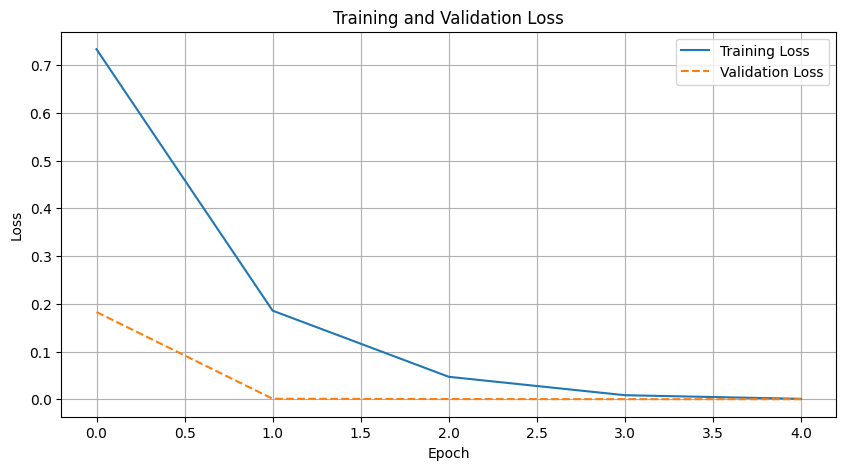

In [53]:
# Visualize the training and testing loss of the model

plt.figure(figsize=(10,5))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

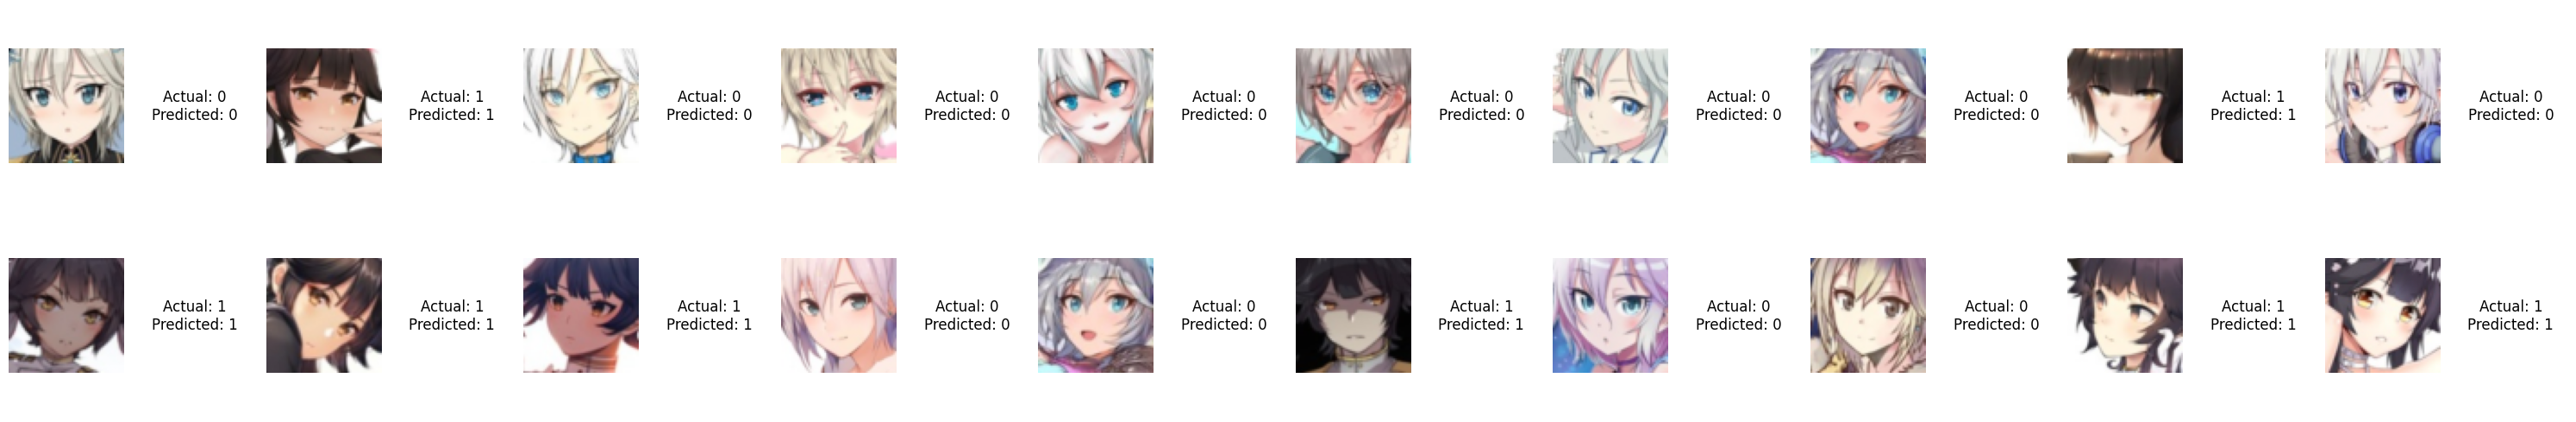

In [54]:
# Function to plot tensor image in matplotlib

def imshow(img,ax):
  img = img / 2 + 0.5
  npimg = img.numpy()
  ax.imshow(np.transpose(npimg,(1,2,0)))
  ax.axis('off')

# Plot the images with true and predicted labels

model.eval()

data_iter=iter(val_loader)
images,labels=next(data_iter)
outputs=model(images)
_,predicted=torch.max(outputs,1)

num_images = len(images)
num_cols = 10
num_rows = 2

fig,axs = plt.subplots(num_rows,num_cols*2,figsize=(30,5))

for idx in range(num_images):
  row = idx // num_cols
  col = (idx % num_cols) * 2

  imshow(images[idx].cpu(),axs[row,col])

  axs[row,col+1].text(0.5,0.5,f'Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}',
                      horizontalalignment='center',verticalalignment='center',fontsize=12)
  axs[row,col+1].axis('off')

for idx in range(num_images,num_rows*num_cols):
  row = idx // num_cols
  col = (idx % num_cols) * 2
  axs[row,col].axis('off')
  axs[row,col+1].axis('off')

plt.tight_layout()
plt.show()

In [55]:
# Check the validation accuracy of the model

correct = 0
total = 0

with torch.no_grad():
  for data in val_loader:
    images,labels=data
    outputs=model(images)
    _,predicted=torch.max(outputs.data,1)
    total += labels.size(0)

    print(f'correct: {correct},total: {total}')

print(f'Validation Accuracy: {100*correct/total:.2f}%')

correct: 20,total: 20
Validation Accuracy: 100.00%


In [60]:
# Experiment another model with a different activation function and epoch number.

class AnimeCNNModified(nn.Module):
  def __init__(self):
    super(AnimeCNNModified,self).__init__()
    self.conv1 = nn.Conv2d(3,32,3,1,padding=1)
    self.conv2 = nn.Conv2d(32,64,3,1,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*16*16,128)
    self.fc2 = nn.Linear(128,2)

  def forward(self,x):
    x = self.pool(F.leaky_relu(self.conv1(x)))
    x = self.pool(F.leaky_relu(self.conv2(x)))
    x = x.view(-1,64*16*16)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [61]:
# Train the new model

model_new = AnimeCNNModified()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(),lr=0.001)

num_epochs = 7
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model_new.train()
  running_loss = 0.0
  for i,data in enumerate(train_loader,0):
    inputs,labels=data
    optimizer.zero_grad()
    outputs=model_new(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)

  model_new.eval()
  val_loss=0.0
  with torch.no_grad():
    for data in val_loader:
      inputs,labels=data
      outputs=model_new(inputs)
      loss=criterion(outputs,labels)
      val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

print('Finished Training')

Epoch: 1/7, Train Loss: 0.3617, Validation Loss: 0.0006
Epoch: 2/7, Train Loss: 0.1493, Validation Loss: 0.0109
Epoch: 3/7, Train Loss: 0.0920, Validation Loss: 0.0046
Epoch: 4/7, Train Loss: 0.0061, Validation Loss: 0.0057
Epoch: 5/7, Train Loss: 0.0124, Validation Loss: 0.0001
Epoch: 6/7, Train Loss: 0.0012, Validation Loss: 0.0001
Epoch: 7/7, Train Loss: 0.0011, Validation Loss: 0.0000
Finished Training


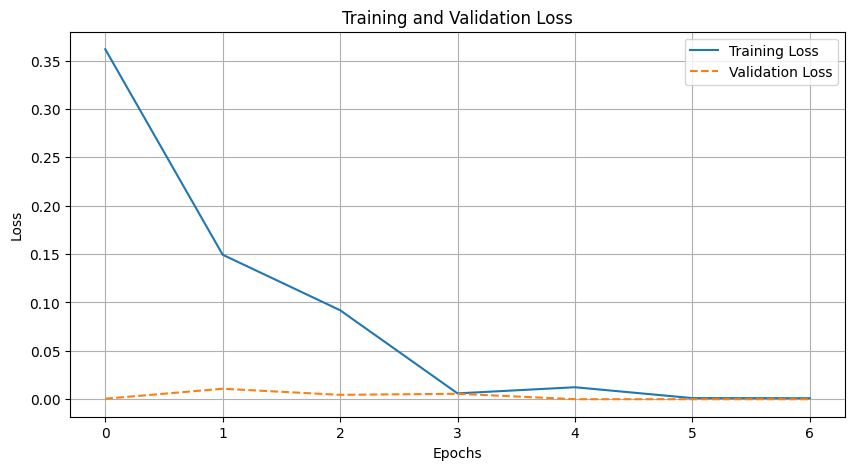

In [62]:
# Visualize the training and test loss of the new model

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()